<a href="https://colab.research.google.com/github/janbanot/msc-cs-code/blob/main/sem3/DL/DL_2025_Lab6-b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uczenie nienadzorowane -- wybrane metody

## Sieci typu koder--dekoder

In [ ]:
%%html
<!-- Potrzebne dla poprawnego wyświetlania paska postępu tqdm w VSCode https://stackoverflow.com/a/77566731 -->
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

In [ ]:
!pip -q install torchinfo

# Import potrzebnych modułów i funkcji

from collections import defaultdict
from random import random

import numpy as np
import torch
import torch.functional as F
from torch import nn, tensor
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Subset
import random
from torchvision import datasets, transforms, models
from PIL import Image

# Importy do wizualizacji
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm

from torchinfo import summary

In [ ]:
def get_device():   # Obliczenia wykonamy na GPU, jeżeli jest dostępne, a na CPU w przeciwny razie
  return torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def train_unsupervised(model, train_loader, test_loader,
                optimizer,
                n_epochs=20, eval_every=1,
                loss_fn=None,
                scheduler=None,
                device=None,
                history=None):
    device = device or get_device()

    history = history or defaultdict(list)
    # Przenieś model na określone urządzenie
    model.to(device)

    # Definiowanie funkcji straty
    compute_loss = loss_fn or nn.CrossEntropyLoss()

    test_loss = history['test_loss'][-1] if history['test_loss'] else 0

    # Pętla treningowa
    for epoch in range(n_epochs):
        model.train()  # Ustaw model w tryb treningowy

        total_loss = 0
        total_samples = 0

        # Iteracja po danych treningowych
        for x_batch, _ in tqdm(train_loader):
            # Przenieś dane na określone urządzenie
            x_batch = x_batch.to(device)

            optimizer.zero_grad()  # Wyzerowanie gradientów przed kolejną iteracją
            out = model(x_batch)  # Faza w przód

            loss = compute_loss(out, x_batch)

            loss.backward()   # Faza wsteczna do obliczenia gradientów
            optimizer.step()  # Aktualizacja parametrów modelu

            total_samples += x_batch.shape[0]
            total_loss += loss.item() * x_batch.shape[0]

        train_loss = total_loss / total_samples

        if (epoch + 1) % eval_every == 0:  # Ewaluacja na zbiorze testowym
            model.eval()   # Ustaw model w tryb ewaluacji
            total_loss = 0
            total_samples = 0
            with torch.no_grad():  # Wyłączenie obliczania gradientów
                for x_batch, _ in tqdm(test_loader):
                    # Przenieś dane na określone urządzenie
                    x_batch = x_batch.to(device)

                    out = model(x_batch)  # Faza w przód

                    loss = compute_loss(out, x_batch)

                    total_samples += x_batch.shape[0]
                    total_loss += loss.item() * x_batch.shape[0]

            test_loss = total_loss / total_samples

            print(f'Epoch: {epoch}\tTrain loss: {train_loss:.3f}'\
                  f'\tTest loss: {test_loss:.3f}')
        else:
            print(f'Epoch: {epoch}\tTrain loss: {train_loss:.3f}')

        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)

        if scheduler:
            scheduler.step()

    return history

In [ ]:
class Autoencoder(nn.Module):
    """ Prosty model typu koder-dekoder """
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        # Koder (ang. encoder)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU()
        )
        # Dekoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()  # Wyj. z zakresu [0, 1]
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self.decode(self.encode(x))

In [ ]:
# Model przetwarza spłaszczone dane, czyli wektory, stąd konieczna jest transformacja
flatten_transform = transforms.Lambda(lambda x: x.view(-1))

# Transformacje, można również dodać odbicia itp
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts images to PyTorch tensors (values between 0 and 1)
    flatten_transform
])

train_dataset = mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = mnist_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [ ]:
torch.manual_seed(123)
device = get_device()

# Hiperparametry
input_dim = 28 * 28   # 784 for 28x28 images
latent_dim = 16       # Wymiar przestrzeni ukrytej
learning_rate = 1e-3

model = Autoencoder(input_dim, latent_dim).to(device)
print(summary(model))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=5)

train_unsupervised(model,
                   train_loader=train_loader, test_loader=test_loader,
                   optimizer=optimizer, scheduler=scheduler,
                   n_epochs=7, loss_fn=nn.BCELoss())

Layer (type:depth-idx)                   Param #
Autoencoder                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       12,560
│    └─ReLU: 2-2                         --
├─Sequential: 1-2                        --
│    └─Linear: 2-3                       13,328
│    └─Sigmoid: 2-4                      --
Total params: 25,888
Trainable params: 25,888
Non-trainable params: 0


  0%|          | 0/1875 [00:00<?, ?it/s]

KeyboardInterrupt: 

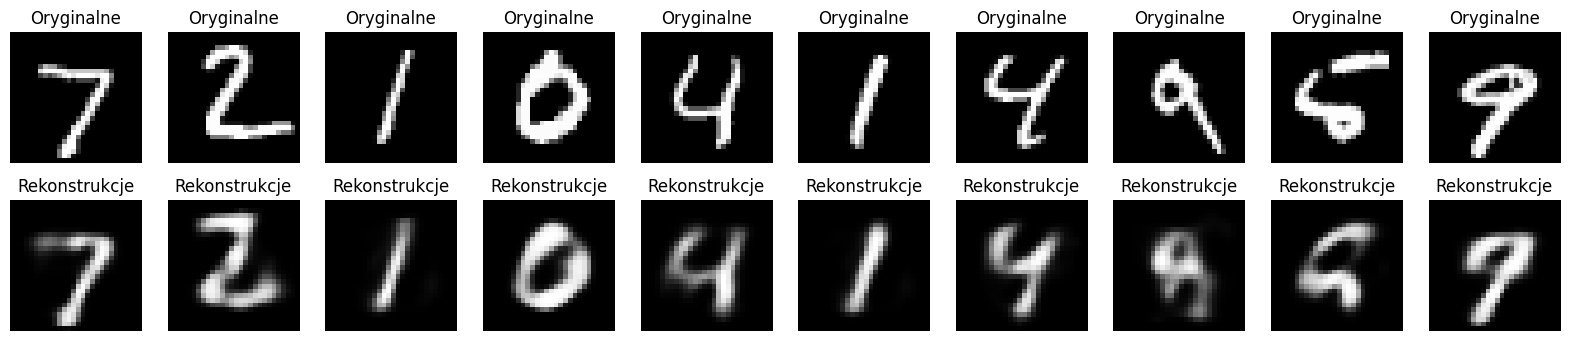

In [ ]:
# Ewaluacja na zb. testowym
model.eval()
with torch.no_grad():
    all_encoded = []
    all_decoded = []
    all_original = []
    for data, _ in test_loader:
        data = data.view(-1, input_dim).to(device)
        encoded = model.encode(data)
        decoded = model.decode(encoded)
        all_encoded.append(encoded.cpu())
        all_decoded.append(decoded.cpu())
        all_original.append(data.cpu())

    decoded_imgs = torch.cat(all_decoded)
    original_imgs = torch.cat(all_original)

decoded_imgs = decoded_imgs.numpy()
original_imgs = original_imgs.numpy()

# Wizualizacja
n_samples = 10
plt.figure(figsize=(20, 4))
for i in range(n_samples):
    # Oryginalne obrazy
    ax = plt.subplot(2, n_samples, i + 1)
    plt.imshow(original_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Oryginalne")
    plt.axis('off')

    # Rekonstrukcje
    ax = plt.subplot(2, n_samples, i + 1 + n_samples)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Rekonstrukcje")
    plt.axis('off')
plt.show()

# Zadanie 1

Proszę sprawdzić jak zmienia się jakość rekonstrukcji w zależności od wymiarowości reprezentacji ukrytej w autokoderze
dla zbioru MNIST oraz FashionMNIST (mogą być wybrane klasy).

Można porównać zarówno "surowe" wartości f. straty, jak i ocenić różnice wizualnie.

# Przestrzeń ukryta - wizualizacja

Mając dostęp do wersji w przestrzeni ukrytej możemy, np. sprawdzić jak wygląda "średnia" wszystkich obrazów
ze zbioru testowego

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

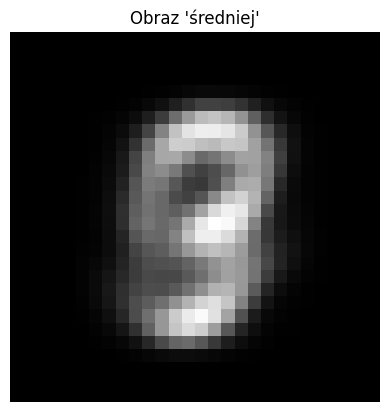

In [ ]:
all_enc = torch.vstack(all_encoded[:-1])  # Łącz listę N wyników dla grup obrazów [64, 32] w [N x 64, 32]

with torch.no_grad():
    model.eval()
    mean_image = model.decode( all_enc.mean(dim=0).to(device) )

plt.imshow(mean_image.cpu().reshape(28, 28), cmap='gray')
plt.title("Obraz 'średniej'")
plt.axis('off')

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

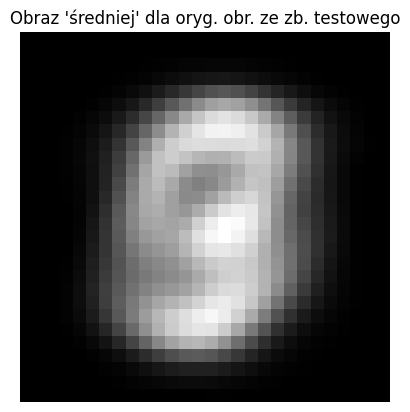

In [ ]:
all_org = torch.vstack(all_original[:-1])  # Łącz listę N wyników dla grup obrazów [64, 32] w [N x 64, 32]
mean_image = all_org.mean(dim=0)

plt.imshow(mean_image.reshape(28, 28), cmap='gray')
plt.title("Obraz 'średniej' dla oryg. obr. ze zb. testowego")
plt.axis('off')

Przestrzeń ukryta (zazwyczaj) ma znacznie mniejszą liczbę wymiarów.
Możemy pokusić się o jej wizualizację na płaszczyźnie.

Jedną z prostszych metod będzie analiza składowych głównych
(ang. Principal Component Analysis, PCA).

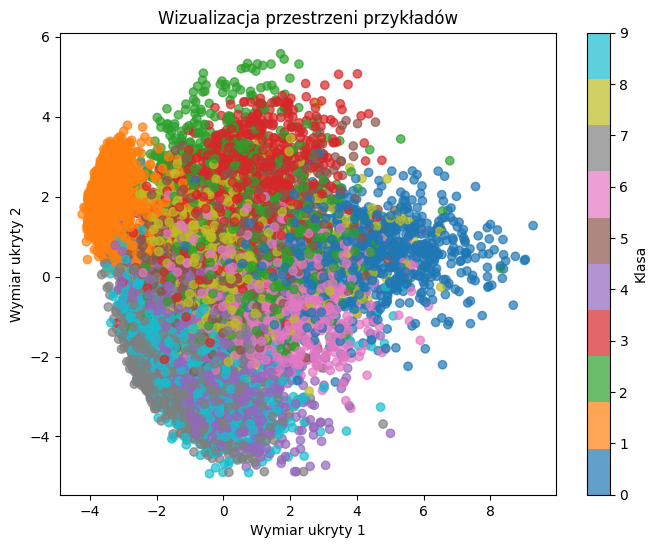

In [ ]:
# Use PCA to reduce dimensions to 2 for visualization
from sklearn.decomposition import PCA

def vizualize_space(samples_stacked, labels,
                    viz_method=None,
                    title='Visualization of the Latent Space'):

    if viz_method is None:
        viz_method = PCA(n_components=2)

    points_2d = viz_method.fit_transform(samples_stacked)

    # Plot the latent space
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(points_2d[:, 0], points_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Klasa')
    plt.xlabel('Wymiar ukryty 1')
    plt.ylabel('Wymiar ukryty 2')
    plt.title(title)
    plt.show()


all_labels = [labels for _, labels in test_loader]
labels = torch.vstack(all_labels[:-1])  # Ostatnia grupa ma rozm. < 64 dlatego ją pomijamy

vizualize_space(all_org, labels, title='Wizualizacja przestrzeni przykładów')

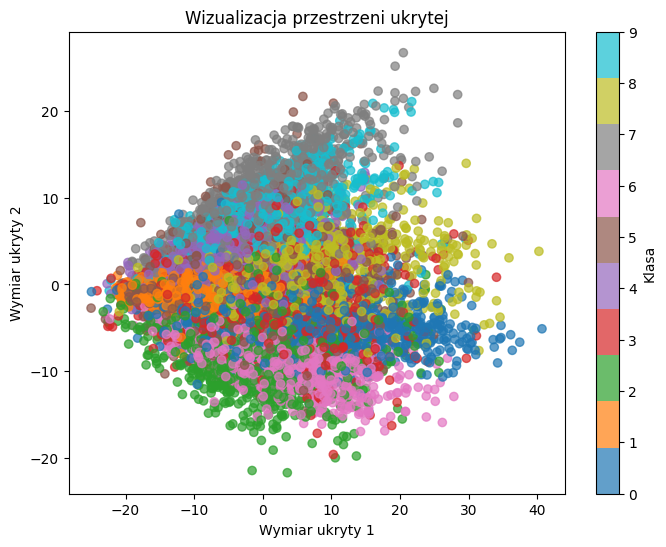

In [ ]:
vizualize_space(all_enc, labels, title='Wizualizacja przestrzeni ukrytej')

## t-SNE

Skrót [t-SNE](https://miroslawmamczur.pl/jak-dziala-metoda-redukcji-wymiarow-t-sne/) oznacza stochastyczną metodę porządkowania sąsiadów w oparciu o rozkład t (t-Distributed Stochastic Neighbor Embedding). Jest to nieliniowa i nienadzorowana technika stosowana przede wszystkim do eksploracji i wizualizacji danych wielowymiarowych.

Może dawać lepsze wyniki niż PCA, ale jest stochastyczna oraz wolniejsza.


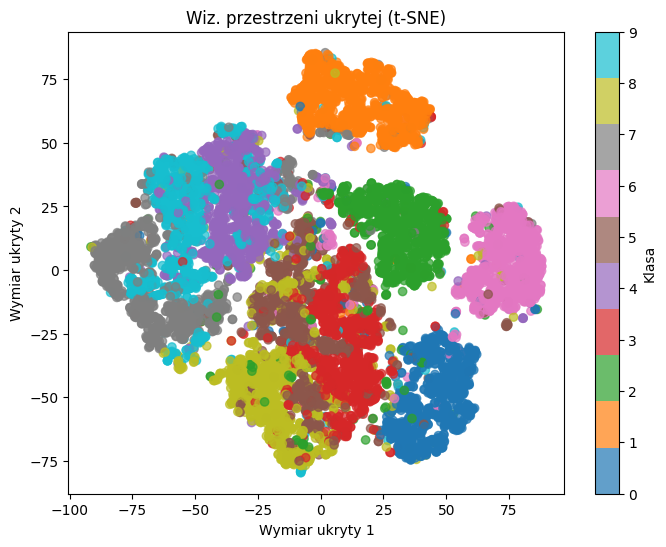

In [ ]:
from sklearn.manifold import TSNE


vizualize_space(all_enc, labels,
                viz_method=TSNE(n_components=2, learning_rate='auto', init='random'),
                title='Wiz. przestrzeni ukrytej (t-SNE)')

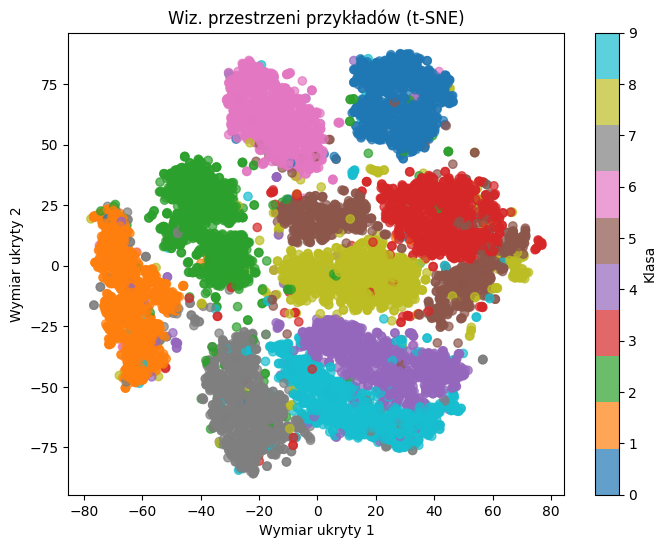

In [ ]:
vizualize_space(all_org, labels,
                viz_method=TSNE(n_components=2, learning_rate='auto', init='random'),
                title='Wiz. przestrzeni przykładów (t-SNE)')

*Wniosek* Autokodery dokonują kompresji wejścia do reprezentacji ukrytej.
Powoduje to "ściśnięcie* klas w przestrzeni na skutek utraty części informacji.

## Autokodery wariacyjne

### Rola Rozbieżności KL w VAE

Wariacyjny Autoenkoder (VAE) nie tylko stara się rekonstruować dane wejściowe na podstawie zakodowanej reprezentacji (jak standardowy koder-dekoder), ale także nakłada *aprioryczny* rozkład na przestrzeń ukrytą, tj. wymusza żeby rozkład ten przypominał zadany rozkład -- zazwyczaj standardowy rozkład normalny $\mathcal{N}(0, I)$.

Podczas treningu VAE dąży do tego, aby rozkład przestrzeni ukrytej (charakteryzowany przez średnią $\mu$ i wariancję $\sigma^2$ dla każdego wejścia) był zbliżony do zadanego rozkładu apriorycznego.

W funkcji straty VAE rozbieżność Kullbacka-Leiblera (KL) mierzy, na ile rozkład kodera odbiega od wybranego rozkładu apriorycznego. Minimalizowanie rozbieżności KL wymusza uporządkowaną strukturę reprezentacji ukrytych i zapobiega zapadaniu się modelu w trywialne rozwiązania. Dzięki temu przestrzeń ukryta będzie miała strukturę **ułatwiającą generowanie nowych**, realistycznych próbek.

### Sztuczka Reparametryzacji

W VAE nie próbkujemy bezpośrednio z rozkładu opisanego przez $\mu$ i $\sigma$, ponieważ próbkowanie **uniemożliwiłoby przepływ gradientów** przez koder. Sztuczka reparametryzacji rozwiązuje ten problem poprzez wyrażenie zmiennej losowej $z$ jako:
$$
z = \mu + \sigma \epsilon
$$
gzie $\epsilon \sim \mathcal{N}(0, I)$. Dzięki temu losowość jest izolowana w $\epsilon$, które nie zależy od parametrów kodera.
Koder **dostarcza $\mu$ i $\sigma$, umożliwiając** obliczanie gradientów.

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=32):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        # Warstwy kodera
        self.encode_l1 = nn.Linear(input_dim, hidden_dim)
        self.mean_layer = nn.Linear(hidden_dim, latent_dim)  # Średnia
        self.log_var_layer = nn.Linear(hidden_dim, latent_dim)  # Log z wariancji
        # Warstwy dekodera
        self.decode_l1 = nn.Linear(latent_dim, hidden_dim)
        self.decode_l2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

    def encode(self, x):
        h = torch.relu(self.encode_l1(x))
        mu = self.mean_layer(h)
        logvar = self.log_var_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Trik reparametryzacji
        # Wariancja musi być dodatnia, e^x to zapewnia:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # Szum
        z = mu + eps * std
        return z

    def decode(self, z):
        h = torch.relu(self.decode_l1(z))
        recon_x = torch.sigmoid(self.decode_l2(h))
        return recon_x


def loss_function(recon_x, x, mu, logvar, beta=1.0):
    # Strata rekonstrukcji (entropia krzyżowa)
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    # Dywergencja KL(N(μ, σ²) || N(0, I))
    variance = logvar.exp()
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - variance)
    return BCE + beta * KLD


model = VAE(latent_dim=64).to(get_device())
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
epochs = 5

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for data, _ in tqdm(train_loader):
        data = data.view(-1, 28 * 28).to(get_device())
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}')

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [1/5], Average Loss: 148.9287


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [2/5], Average Loss: 118.5270


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [3/5], Average Loss: 112.6613


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [4/5], Average Loss: 110.4670


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [5/5], Average Loss: 109.1592


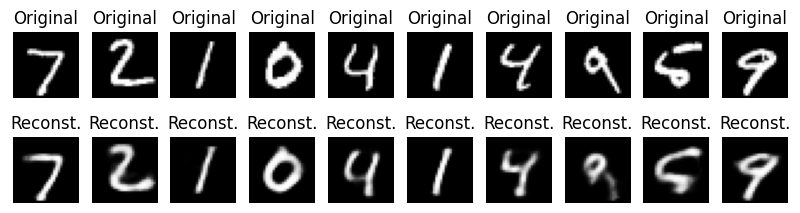

In [ ]:
def show_vae_output(model, n_samples=10):
    model.eval()
    with torch.no_grad():
        all_decoded = []
        all_original = []
        for data, _ in test_loader:
            data = data.view(-1, input_dim).to(get_device())
            decoded, _, _ = model(data)
            all_decoded.append(decoded.cpu())
            all_original.append(data.cpu())

        decoded_imgs = torch.cat(all_decoded)
        original_imgs = torch.cat(all_original)

    # Wizualizacja

    decoded_imgs = decoded_imgs.numpy()
    original_imgs = original_imgs.numpy()

    n_samples = 10
    plt.figure(figsize=(10, 2.5))
    for i in range(n_samples):
        ax = plt.subplot(2, n_samples, i + 1)
        plt.imshow(original_imgs[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        ax = plt.subplot(2, n_samples, i + 1 + n_samples)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.title("Reconst.")
        plt.axis('off')
    plt.show()


show_vae_output(model)

Nieco lepsze rezultaty możemy osiągnąć dodając do VAE warsty konwolucyjne.

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Koder -- prosta sieć konwolucyjna
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # (batch, 32, 14, 14)
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # (batch, 64, 7, 7)
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0),# (batch, 128, 3, 3)
            nn.Flatten(),
        )
        # Wstrzykujemy informację o klasie przykładu, stąd " + num_classes"
        self.fc_mu = nn.Linear(128 * 3 * 3, latent_dim)
        self.fc_logvar = nn.Linear(128 * 3 * 3, latent_dim)

        # Dekoder  -- również sieć konwolucyjna
        self.decoder_input = nn.Linear(latent_dim, 128 * 3 * 3)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0),  # (batch, 64, 7, 7)
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # (batch, 32, 14, 14)
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),    # (batch, 1, 28, 28)
            nn.Flatten(),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = x.view(x.size(0), 1, 28, 28)
        enc = self.encoder(x)
        mu = self.fc_mu(enc)
        logvar = self.fc_logvar(enc)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        return mu + epsilon * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 128, 3, 3)
        reconstructed = self.decoder(x)
        return reconstructed

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mu, logvar


model = VAE().to(get_device())
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
epochs = 5

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for data, _ in tqdm(train_loader):
        data = data.view(-1, 28 * 28).to(get_device())
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
                             #beta=0.5 + 0.5 * (1. + epoch) / epochs)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}')

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [1/5], Average Loss: 128.0898


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [2/5], Average Loss: 106.0986


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [3/5], Average Loss: 104.1086


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [4/5], Average Loss: 103.0213


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [5/5], Average Loss: 102.3324


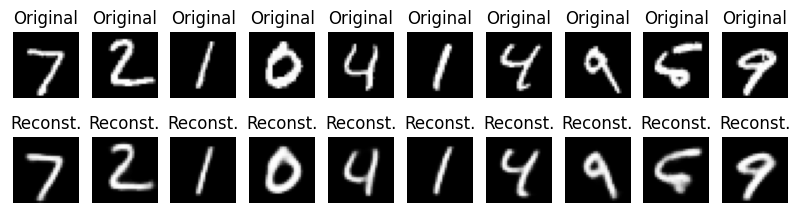

In [ ]:
show_vae_output(model)

### Próbkowanie przestrzeni ukrytej

Próbkowanie przestrzeni ukrytej polega na wybraniu losowej próbki z wielowymiarowego rozkładu normalnego
$\mathcal{N}(0, 1)$

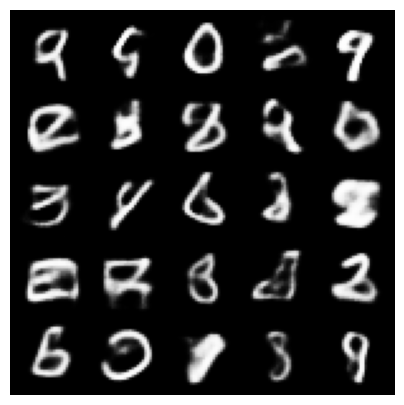

In [ ]:
import torchvision.utils as vutils

def show_images(images):
    nrow = ncol = int(len(images) ** 0.5 + 0.5)
    grid = vutils.make_grid(images, nrow=nrow, padding=2, normalize=True)
    np_grid = grid.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(ncol, nrow))
    plt.imshow(np_grid, cmap='gray')
    plt.axis('off')

def sample_model(model, num_samples=16):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim)
        z = z.to(get_device())
        generated = model.decode(z).cpu()
        generated = generated.view(num_samples, 1, 28, 28)
    return generated


show_images(sample_model(model, num_samples=5*5))

Możemy wygenerować próbki skupione w sąsiedztwie podanego przykładu.
W tym celu korzystamy z kodera w celu uzyskania parametrów, tj. średniej
oraz odchylenia, dla podanego przykładu i stosujemy je przy losowaniu.

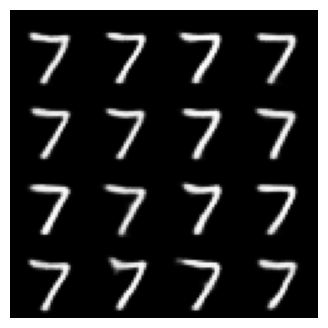

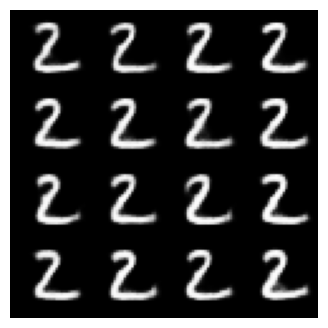

In [ ]:
def sample_neighborhood(vae, x, num_samples=5):
    """ Zwraca próbki w sąsiedztwie podanego przykładu 'x' """
    vae.eval()
    with torch.no_grad():
        mu, logvar = vae.encode(x)
        # Repeat mu and logvar for num_samples times
        mu = mu.repeat(num_samples, 1)
        logvar = logvar.repeat(num_samples, 1)
        # Sample latent vectors using the reparameterization trick
        z = vae.reparameterize(mu, logvar)
        reconstructions = vae.decode(z).view(num_samples, 1, 28, 28).cpu()
    return reconstructions


img_batch, _ = next(iter(test_loader))

for example_id in range(2):
    input_image = img_batch[example_id].view(-1, 28*28).to(get_device())
    reconstructions = sample_neighborhood(model, input_image, num_samples=4*4)
    show_images(reconstructions)

### Interpolacja pomiędzy przykładami


Koder dokonuje "kompresji" obrazu do wektora w przestrzeni ukrytej.
Mając wektory dla pary przykładów, możemy dokonać prostej interpolacji pomiędzy nimi
otrzymując przykłady łączące cechy obu obrazów.

(np.float64(-0.5), np.float64(271.5), np.float64(31.5), np.float64(-0.5))

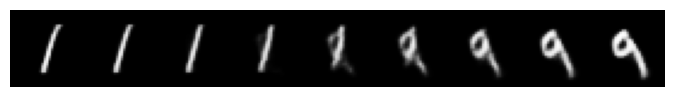

In [ ]:
model.eval()

digit_label1, digit_label2 = 1, 9  # Klasy obrazów
img1, img2 = None, None  # Wybrane obrazy

# Znajdź obrazy z obu klas
for img_batch, label_batch in test_loader:
    for img, label in zip(img_batch, label_batch):
        if label.item() == digit_label1 and img1 is None:
            img1 = img
        if label.item() == digit_label2 and img2 is None:
            img2 = img
        if img1 is not None and img2 is not None:
            break
    if img1 is not None and img2 is not None:
        break

device = get_device()
img1 = img1.unsqueeze(0).to(device)  # Shape: [1, 1, 28, 28]
img2 = img2.unsqueeze(0).to(device)

steps = 9

with torch.no_grad():
    # Zakoduj obrazy do postaci ukrytej
    mu1, logvar1 = model.encode(img1)
    z1 = model.reparameterize(mu1, logvar1)

    mu2, logvar2 = model.encode(img2)
    z2 = model.reparameterize(mu2, logvar2)

    # Współczynniki interpolacji
    alphas = torch.linspace(0, 1, steps).to(device).unsqueeze(1)

    # Właściwa interpolacja
    z_interp = z1 * (1 - alphas) + z2 * alphas  # Shape: [steps, latent_dim]

    # Dekoduj obrazy
    generated = model.decode(z_interp).cpu()
    generated = generated.view(steps, 1, 28, 28)

# Wyświetl
grid = vutils.make_grid(generated, nrow=len(generated), padding=2, normalize=True)
np_grid = grid.numpy().transpose((1, 2, 0))
plt.figure(figsize=(len(generated), 1))
plt.imshow(np_grid, cmap='gray')
plt.axis('off')

## Warunkowanie

Bazowa wersja VAE nie daje nam kontroli nad tym jakiej klasy przykład uzyskamy
losując wektor z przestrzeni ukrytej. Jeżeli na wejście sieci będziemy podawać
również docelowe etykiety przykładów, to będziemy mogli **warunkować**
pracę dekodera, tj. uzależnić wynik od pożądanej klasy docelowej.

In [ ]:
import torch
import torch.nn as nn

class CondVAE(nn.Module):
    def __init__(self, num_classes, latent_dim=32):
        super(CondVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Koder -- prosta sieć konwolucyjna
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # (batch, 32, 14, 14)
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # (batch, 64, 7, 7)
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0),# (batch, 128, 3, 3)
            nn.Flatten(),
        )
        # Wstrzykujemy informację o klasie przykładu, stąd " + num_classes"
        self.fc_mu = nn.Linear(128 * 3 * 3 + num_classes, latent_dim)
        self.fc_logvar = nn.Linear(128 * 3 * 3 + num_classes, latent_dim)

        # Dekoder  -- również sieć konwolucyjna
        self.decoder_input = nn.Linear(latent_dim + num_classes, 128 * 3 * 3)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0),  # (batch, 64, 7, 7)
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # (batch, 32, 14, 14)
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),    # (batch, 1, 28, 28)
            nn.Flatten(),
            nn.Sigmoid(),
        )

    def encode(self, x, labels):
        x = x.view(x.size(0), 1, 28, 28)
        features = self.encoder(x)
        labels_onehot = nn.functional.one_hot(labels, num_classes=self.num_classes).float()
        combined = torch.cat([features, labels_onehot], dim=1)
        mu = self.fc_mu(combined)
        logvar = self.fc_logvar(combined)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        return mu + epsilon * std

    def decode(self, z, labels):
        labels_onehot = nn.functional.one_hot(labels, num_classes=self.num_classes).float()
        z = torch.cat([z, labels_onehot], dim=1)
        x = self.decoder_input(z)
        x = x.view(-1, 128, 3, 3)
        reconstructed = self.decoder(x)
        return reconstructed

    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        reconstructed_x = self.decode(z, labels)
        return reconstructed_x, mu, logvar

In [ ]:
# Trening

model = CondVAE(latent_dim=64, num_classes=10).to(get_device())
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
epochs = 5

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for data, labels in tqdm(train_loader):
        data = data.view(-1, 28 * 28).to(get_device())
        labels = labels.to(get_device())
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar, beta=4)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}')

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [1/5], Average Loss: 162.7559


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [2/5], Average Loss: 142.4625


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [3/5], Average Loss: 138.8473


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [4/5], Average Loss: 137.0710


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [5/5], Average Loss: 135.7730


### Warunkowane próbkowanie

Do losowego wektora w przestrzeni ukrytej na wejście dekodera podajemy również
pożądaną klasę (etykietę) wyniku.

In [ ]:
def sample_and_display_cond(model, label, num_samples=9):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim)
        labels = torch.full((num_samples, ), label).to(get_device())
        z = z.to(get_device())
        generated = model.decode(z, labels).cpu()
        generated = generated.view(num_samples, 1, 28, 28)
    show_images(generated)

for i in range(0, 10):
    sample_and_display_cond(model, label=i)

# Zadanie 2

Proszę sprawdzić działanie autokodera wariacyjnego na zbiorze FashionMNIST.
Zbiór ten jest bardziej wymagający niż MNIST, stąd proszę rozważyć:

- większą liczbę epok treningu
- większy wymiar reprezentacji ukrytej zamiast, tj. > 64
- większy rozmiar modelu, np. liczbę kanałów w modułach konwolucyjnych